# Fitting of data for Donghoon

In [1]:
%load_ext autoreload
%autoreload 2

from tqdm import tqdm
import matplotlib.pyplot as plt
from pynwb import TimeSeries
from pynwb import NWBHDF5IO
import pandas as pd
import numpy as np
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "1,2,3,4"
import jax


## Load spikes data

In [ ]:
from spyglass.common import TaskEpoch, IntervalList
from spyglass.common.common_interval import Interval

key = {
    "nwb_file_name": "SC10420250628_.nwb",
    "task_environment": "Y-maze",
}
interval_query = (TaskEpoch * IntervalList) & key
intervals = interval_query.fetch("valid_times")

intervals = intervals[0]  # Just the first epoch for now
# intervals = np.concatenate(intervals)
run_intervals = Interval(intervals)

[2025-10-10 14:42:44,862][INFO]: Connecting sambray@lmf-db.cin.ucsf.edu:3306
[2025-10-10 14:42:44,983][INFO]: Connected sambray@lmf-db.cin.ucsf.edu:3306


In [3]:
from spyglass.spikesorting.analysis.v1.group import SortedSpikesGroup

key = {
    "nwb_file_name": "SC10420250628_.nwb",
    "sorted_spikes_group_name": "PFC_exclude_all_other2",
}

query = SortedSpikesGroup() & key
spikes_data = query.fetch_spike_data(key)

/home/sambray/mambaforge-pypy3/envs/spyglass2025/lib/python3.10/site-packages/hdmf/spec/namespace.py:583: UserWarning: Ignoring the following cached namespace(s) because another version is already loaded:
core - cached version: 2.7.0, loaded version: 2.8.0
ndx-franklab-novela - cached version: 0.1.0, loaded version: 0.2.1
The loaded extension(s) may not be compatible with the cached extension(s) in the file. Please check the extension documentation and ignore this warning if these versions are compatible.
  self.warn_for_ignored_namespaces(ignored_namespaces)
/home/sambray/mambaforge-pypy3/envs/spyglass2025/lib/python3.10/site-packages/hdmf/spec/namespace.py:583: UserWarning: Ignoring the following cached namespace(s) because another version is already loaded:
core - cached version: 2.7.0, loaded version: 2.8.0
ndx-franklab-novela - cached version: 0.1.0, loaded version: 0.2.1
The loaded extension(s) may not be compatible with the cached extension(s) in the file. Please check the exten

In [4]:
# Filter for spikes within the run intervals
spike_times = [run_intervals.contains(s) for s in spikes_data]

In [5]:
cluster_id = None

spike_times = []
spike_ids = []
id_ = 0
for i, s in enumerate(spikes_data):
    spike_times.extend(s)
    spike_ids.extend([id_] * len(s))
    id_ += 1
print(f"{id_} units")
spike_times = np.array(spike_times)
spike_ids = np.array(spike_ids)
ind = np.argsort(spike_times)
spike_times = spike_times[ind]
spike_ids = spike_ids[ind]

delta_t = np.diff(spike_times)

ind_pos = np.where(delta_t > 0)[0]
spike_ids = spike_ids[ind_pos]
spike_times = spike_times[ind_pos]
delta_t = delta_t[ind_pos]
waveforms = spike_ids.copy()

delta_t.shape, waveforms.shape

1010 units


((78071472,), (78071472,))

In [7]:
np.median(delta_t)

0.00010013580322265625

In [ ]:
# seg_length = 1000
# n_overlap = 30
seg_length = 50000
n_overlap = 30007
min_run_frac = 1.0  # minimum fraction of segment that must be in a run interval

# n_segments = (len(delta_t) - seg_length) // n_overlap + 1

valid_times = np.zeros(spike_times.size, dtype=bool)
ind_valid = run_intervals.contains(spike_times, as_indices=True)
valid_times[ind_valid] = True

delta_t_train = []
waveforms_train = []
for i in tqdm(range(0, len(delta_t) - seg_length, seg_length - n_overlap)):
    start = i
    end = start + seg_length
    if np.mean(valid_times[start:end]) < min_run_frac:
        continue
    if np.max(delta_t[start:end] > 1):  # skip segments with large gaps
        continue
    delta_t_train.append(delta_t[start : end - 1])
    waveforms_train.append(waveforms[start : end - 1])
delta_t_train = np.array(delta_t_train, dtype=np.float32)
waveforms_train = np.array(waveforms_train, dtype=np.int16)[..., None]
print(delta_t_train.shape, waveforms_train.shape)
# delta_t_train *= 1000  # convert to ms

100%|██████████| 3903/3903 [00:00<00:00, 18355.23it/s]


(1118, 49999) (1118, 49999, 1)


In [26]:
np.mean(delta_t_train)

0.00014990059

# Make Model

In [ ]:
import os

if "src" not in os.listdir():
    os.chdir("..")

In [ ]:
# prep data for model
from src.c3po.model.util import prep_training_data
from src.c3po.model.model import C3PO

keep_params = 0  # True

if keep_params:
    store_params = params.copy()


# hyperparams
latent_dim = 20  # 4
context_dim = 20

n_neg_samples = 16
encoder_args = dict(
    encoder_model="sorted_spikes",
    n_units=waveforms_train.shape[-1],
    gauss_noise_std=0,
    input_format="indices",
)

# encoder_args = dict(encoder_model="identity")
# latent_dim = waveforms_train.shape[-1]

# v4

# dilations = [
#     1,
#     2,
#     4,
#     8,
#     8,
#     16,
# ]
# dilations = dilations * 2
# kernels = [8, 8, 16, 16, 16, 16]
# kernels = kernels * 2
# dilations = [
#     1,
#     10,
# ]
# kernels = [10, 8]

# dilations = dilations + 2 * [1,2,4,8,16,32]
# kernels = kernels + 2 * [2,2,2,2,2,2]

# # kernels = [10, 8, 8, 8]
# # dilations = dilations * 2
# # kernels = kernels * 2

# # V2
# dilations = [1, 2, 2, 4, 8]
# # dilations = dilations * 2
# kernels = [32, 32, 64, 128, 256]
# # kernels = kernels * 2

# dilations = dilations + [1, 2, 4, 8, 16, 32]
# kernels = kernels + [4, 4, 4, 4, 4, 4]

default_dilation = 32
dilations = [1, 2, 4, 8, 16, 32]
dilations = dilations + dilations
dilations = [d * default_dilation for d in dilations]
kernels = [32] + [16] * len(dilations[1:])

context_args = dict(
    context_model="wavenet",
    layer_dilations=dilations,
    layer_kernel_size=kernels,
    expanded_dim=64,
    smoothing=50,
    smoothing_decay=0.999,
    categorical=False,
)

# context_args_slow = dict(
#     context_model="wavenet",
#     layer_dilations=[1, 10, 30, 30],
#     layer_kernel_size=[10, 10, 10, 30],
#     expanded_dim=32,
#     smoothing=100,
#     smoothing_decay=0.99,
#     categorical=False,
# )

# context_args_fast = dict(
#     context_model="wavenet",
#     layer_dilations=[1, 2, 4, 8, 16, 32] * 2,
#     layer_kernel_size=[4, 4, 4, 4, 4, 4] * 2,
#     expanded_dim=32,
#     smoothing=5,
#     smoothing_decay=0.5,
#     categorical=False,
# )

# context_args = dict(
#     context_model="multi_model",
#     model_args=[context_args_slow, context_args_fast],
# )


# rate_args = dict(
#     rate_model="bilinear",
# )
rate_args = dict(rate_model="sharedSpace")

distribution = "poisson"  # "multi_loglogistic"  # "gompertz"
predicted_sequence_length = 1


model = C3PO(
    encoder_args,
    context_args,
    rate_args,
    distribution,
    latent_dim,
    context_dim,
    n_neg_samples,
    predicted_sequence_length,
    return_embeddings_in_call=True,
)


rand_key = jax.random.PRNGKey(0)
params = model.init(
    jax.random.PRNGKey(1), waveforms_train[:2, :300], delta_t_train[:2, :300], rand_key
)
init_params = params.copy()
run_model = jax.jit(model.apply)
if keep_params:
    params = store_params.copy()

# Train Model (MULTI GPU)

In [209]:
waveforms_train.shape, delta_t_train.shape

((1118, 49999, 1), (1118, 49999))

In [ ]:
from jax import pmap, value_and_grad

params = jax.device_put_replicated(init_params, jax.devices())
# prior_params = {
#     "mu": -np.mean(np.log(delta_t_train)),
#     "sigma": np.std(np.log10(delta_t_train)),
# }
# prior_params

from jax import pmap


loss_inds = slice(-30000, None)


def stalled_training(loss_history):
    val = loss_history[-3:]
    if np.std(val) / np.mean(val) < 1e-2:
        return True
    return False


def change_n_neg_samples(params, x, delta_t, rand_key, n_neg_samples):
    model = C3PO(
        encoder_args,
        context_args,
        rate_args,
        distribution,
        latent_dim,
        context_dim,
        n_neg_samples,
        predicted_sequence_length,
        return_embeddings_in_call=True,
    )
    run_model = jax.jit(model.apply)

    def training_loss_fun(params, x, delta_t, rand_key):
        pos_params, neg_params, z, c, neg_z = run_model(params, x, delta_t, rand_key)
        return model.contrastive_loss(
            pos_params[:, :, loss_inds],
            neg_params[:, :, loss_inds],
            delta_t[:, loss_inds],
            z[:, predicted_sequence_length:][:, loss_inds],
            neg_z[:, :, loss_inds],
        )

    @pmap
    def compute_gradients(params, x, delta_t, rand_key):
        # def training_loss_fun(params, x, delta_t, rand_key):
        #     pos_params, neg_params = run_model(params, x, delta_t, rand_key)
        #     return model.contrastive_loss(
        #         pos_params,
        #         neg_params,
        #         delta_t,
        #         scale_neg_samples=2 * predicted_sequence_length,
        #         sample_step=2,
        #         rand_key=rand_key,
        #         prior_params=prior_params,
        #     )

        loss, grads = value_and_grad(training_loss_fun)(params, x, delta_t, rand_key)
        return loss, grads

    def run_batches(params, opt_state, x, delta_t, rand_key):
        x_batch, delta_t_batch = get_batches(
            x,
            delta_t,
        )
        losses, grads = compute_gradients(
            params, x_batch, delta_t_batch, jax.random.split(rand_key, num_devices)
        )
        rand_key = jax.random.split(rand_key)[0]

        # Optional: Apply updates separately per GPU
        updates, opt_state = optimizer.update(grads, opt_state, params)
        params = optax.apply_updates(params, updates)
        return params, opt_state, np.mean(losses)

    return run_batches


# # Function to generate independent batches per device
def get_batches(x, delta_t):
    """Simulate getting independent batches for each device."""
    return np.array([x[i::num_devices] for i in range(num_devices)]), np.array(
        [delta_t[i::num_devices] for i in range(num_devices)]
    )

In [108]:
r = model.apply(
    jax.tree_map(lambda x: x[0], params), x_train[:4], delta_t_train[:4], rand_key
)

In [109]:
[__.shape for __ in r]

[(4, 1, 49998, 1),
 (4, 16, 49998, 1),
 (4, 49999, 64),
 (4, 49999, 16),
 (4, 16, 49998, 64)]

In [ ]:
x_train = waveforms_train.copy()

In [ ]:
batch_size = 8
n_neg = 4  # n_neg_samples
tracked_loss = []
tracked_n_neg = []
tracked_batch_size = []
default_buffer = 4
epoch_subsample = 1  # use this fraction of data each epoch
learning_rate = 3e-4

buffer = default_buffer
from tqdm import tqdm

# Number of available GPUs
num_devices = jax.device_count()
# Define batch size per GPU
total_batch_size = batch_size * num_devices
clip_sample = x_train.shape[1]

import optax

optimizer = optax.chain(
    optax.adam(learning_rate),
)
# Initialize model parameters and optimizer
opt_state = optimizer.init(params)
run_batches = change_n_neg_samples(
    params, waveforms_train, delta_t_train, rand_key, n_neg_samples
)
for i in range(30000):
    ind = np.arange(x_train.shape[0])
    np.random.shuffle(ind)
    ind = ind[: x_train.shape[0] // epoch_subsample]

    epoch_loss = []
    j = 0
    with tqdm(
        total=x_train.shape[0], desc=f"Epoch {i+1}/{3000}", unit="samples"
    ) as pbar:
        while j < ind.shape[0]:
            # Perform one gradient update.
            rand_key, _ = jax.random.split(rand_key)
            batch_inds = ind[j : j + total_batch_size]
            if batch_inds.shape[0] < total_batch_size:
                break
            # loss_val, grads = loss_grad_fn(
            #     params,
            #     x_train[batch_inds, :clip_sample],
            #     delta_t_train[batch_inds, :clip_sample],
            #     rand_key,
            # )
            # updates, opt_state = optimizer.update(grads, opt_state, params)
            # params = optax.apply_updates(params, updates)
            x_batch = x_train[batch_inds, :clip_sample]
            delta_t_batch = delta_t_train[batch_inds, :clip_sample]
            params, opt_state, loss_val = run_batches(
                params, opt_state, x_batch, delta_t_batch, rand_key
            )
            rand_key = jax.random.split(rand_key)[0]
            epoch_loss.append(loss_val)

            j += total_batch_size

            pbar.update(total_batch_size)
            pbar.set_postfix(
                loss=np.mean(epoch_loss), n_neg=n_neg, batch_size=batch_size
            )

    tracked_loss.append(np.mean(epoch_loss))
    tracked_n_neg.append(n_neg)
    tracked_batch_size.append(batch_size)
    # z_tracked, c_tracked = embed_tracked_samples(params)
    # for t, c, a in zip(delta_t_train[track_samples], c_tracked, ax.flatten()):
    #     a.plot(np.cumsum(t), c)
    # fig.savefig(f"sb1/{i:04}.png")
    # for a in ax.flatten():
    #     a.clear()

    buffer -= 1

    if buffer > 0 or (not stalled_training(tracked_loss)):
        continue
    if n_neg < 200:
        n_neg *= 2
        # loss_grad_fn = change_n_neg_samples(
        #     params, x_train, delta_t_train, rand_key, n_neg
        # )
        run_batches = change_n_neg_samples(
            params, x_train, delta_t_train, rand_key, n_neg
        )
        buffer = default_buffer
    elif batch_size > 2:
        batch_size /= 2
        batch_size = int(batch_size)
        total_batch_size = int(batch_size * num_devices)
        n_neg = 4
        run_batches = change_n_neg_samples(
            params, x_train, delta_t_train, rand_key, n_neg
        )
        # loss_grad_fn = jax.value_and_grad(training_loss_fun)
        buffer = default_buffer
    else:
        break

Epoch 84/3000:  99%|█████████▉| 1112/1118 [01:07<00:00, 16.37samples/s, batch_size=2, loss=5.55, n_neg=256]


# Train Model SINGLE GPU

In [21]:
from src.c3po.model.model import loss


def change_n_neg_samples(params, x, delta_t, rand_key, n_neg_samples):
    model = C3PO(
        encoder_args,
        context_args,
        rate_args,
        distribution,
        latent_dim,
        context_dim,
        n_neg_samples,
        predicted_sequence_length,
        return_embeddings_in_call=True,
    )
    run_model = jax.jit(model.apply)

    def training_loss_fun(params, x, delta_t, rand_key):
        pos_params, neg_params, z, c, neg_z = run_model(params, x, delta_t, rand_key)
        return model.contrastive_loss(
            pos_params,
            neg_params,
            delta_t,
            z[:, predicted_sequence_length:],
            neg_z,
        )

    return jax.value_and_grad(training_loss_fun)


def training_loss_fun(params, x, delta_t, rand_key):
    model = C3PO(
        encoder_args,
        context_args,
        rate_args,
        distribution,
        latent_dim,
        context_dim,
        n_neg_samples,
        predicted_sequence_length,
        return_embeddings_in_call=True,
    )
    run_model = jax.jit(model.apply)

    pos_params, neg_params, z, c, neg_z = run_model(params, x, delta_t, rand_key)
    return model.contrastive_loss(
        pos_params,
        neg_params,
        delta_t,
        z[:, predicted_sequence_length:],
        neg_z,
    )


loss_grad_fn = jax.value_and_grad(training_loss_fun)

In [24]:
from tqdm import tqdm
import optax


learning_rate = 4e-3
batch_size = 4
n_neg = 4

# batch_size = 64
# n_neg = 32

# print(loss_grad_fn(params, x_train[:10], delta_t_train[:10], rand_key)[0])
import optax

optimizer = optax.chain(
    # optax.clip_by_global_norm(1),
    optax.adam(learning_rate),
    # optax.clip_by_block_rms(0.1),
    # optax.adadelta(learning_rate),
)
# Initialize parameters of the model + optimizer.
opt_state = optimizer.init(params)


loss_grad_fn = change_n_neg_samples(
    params, waveforms_train, delta_t_train, rand_key, n_neg
)
tracked_loss = []
buffer = 5
for i in range(5000):
    ind = np.arange(waveforms_train.shape[0])
    np.random.shuffle(ind)
    epoch_loss = []
    j = 0
    with tqdm(
        total=waveforms_train.shape[0], desc=f"Epoch {i+1}/{3000}", unit="samples"
    ) as pbar:
        prev_params = params.copy()  # store params from end of previous epoch
        while j < waveforms_train.shape[0] // 2:
            # Perform one gradient update.
            rand_key, _ = jax.random.split(rand_key)
            batch_inds = ind[j : j + batch_size]
            if len(batch_inds) < batch_size:
                break
            loss_val, grads = loss_grad_fn(
                params, waveforms_train[batch_inds], delta_t_train[batch_inds], rand_key
            )
            if not np.isfinite(loss_val):
                params = prev_params.copy()
                raise ValueError("Loss is not finite")
            # print(loss_val)
            epoch_loss.append(loss_val)
            updates, opt_state = optimizer.update(grads, opt_state, params)
            params = optax.apply_updates(params, updates)
            j += batch_size

            pbar.update(batch_size)
            pbar.set_postfix(
                loss=f"{np.mean(epoch_loss):<.4f}", n_neg=n_neg, batch_size=batch_size
            )
            # break
    tracked_loss.append(np.mean(epoch_loss))
    # if i < 10:
    #     continue
    buffer -= 1
    if (np.mean(tracked_loss[-5:-1]) < tracked_loss[-1] * 1.003) and buffer <= 0:
        if n_neg < 60:  # 120:
            n_neg *= 2
            jax.clear_caches()
            del loss_grad_fn
            loss_grad_fn = change_n_neg_samples(
                params, waveforms_train, delta_t_train, rand_key, n_neg
            )
            buffer = 10
        elif batch_size > 32:
            n_neg = 8
            batch_size = int(batch_size // 2)
            jax.clear_caches()
            del loss_grad_fn
            loss_grad_fn = change_n_neg_samples(
                params, waveforms_train, delta_t_train, rand_key, n_neg
            )
            buffer = 10
        else:
            break
            # n_neg = 128
            # batch_size = 32
            # buffer = 5

Epoch 1/3000:   0%|          | 0/11193 [00:00<?, ?samples/s]2025-10-10 14:40:32.774027: W external/xla/xla/stream_executor/cuda/cuda_command_buffer.cc:668] Retry CUDA graph instantiation after OOM error
E1010 14:40:32.774305  326722 pjrt_stream_executor_client.cc:3026] Execution of replica 0 failed: RESOURCE_EXHAUSTED: Underlying backend ran out of memory trying to instantiate graph with 30 nodes and 0 conditionals (total of 0 alive graphs in the process). You can try to (a) Give more memory to the driver by reducing XLA_CLIENT_MEM_FRACTION (b) Disable command buffers with 'XLA_FLAGS=--xla_gpu_enable_command_buffer=' (empty set). Original error: Failed to instantiate CUDA graph: CUDA_ERROR_OUT_OF_MEMORY: out of memory
Epoch 1/3000:   0%|          | 0/11193 [00:03<?, ?samples/s]


XlaRuntimeError: RESOURCE_EXHAUSTED: Underlying backend ran out of memory trying to instantiate graph with 30 nodes and 0 conditionals (total of 0 alive graphs in the process). You can try to (a) Give more memory to the driver by reducing XLA_CLIENT_MEM_FRACTION (b) Disable command buffers with 'XLA_FLAGS=--xla_gpu_enable_command_buffer=' (empty set). Original error: Failed to instantiate CUDA graph: CUDA_ERROR_OUT_OF_MEMORY: out of memory

In [23]:
jax.clear_caches()

# Analyze

In [ ]:
from src.c3po.analysis.analysis import C3poAnalysis

analysis_encoder_args = {**encoder_args}
# analysis_encoder_args.update({"gauss_noise_std": 0})
model_args = dict(
    encoder_args=analysis_encoder_args,
    context_args=context_args,
    rate_args=rate_args,
    distribution=distribution,
    latent_dim=latent_dim,
    context_dim=context_dim,
    n_neg_samples=n_neg_samples,
    predicted_sequence_length=predicted_sequence_length,
    sample_params=None,
)
analysis = C3poAnalysis(
    model=model, model_args=model_args, params=jax.tree_map(lambda x: x[0], params)
)

In [148]:
# ind = run_intervals.contains(spike_times, as_indices=True)[:1000000]

In [214]:
# embed data and make pca
ind = slice(0, 1000000)
analysis.embed_data(
    waveforms[None, ind, None],
    delta_t[None, ind],
    delta_t_units="s",
    first_mark_time=spike_times[0],
    chunk_size=190000,
)
# t_interp = np.arange(np.min(spike_times), np.max(spike_times), 0.001)
# analysis.interpolate_context(t_interp)
analysis.fit_context_pca()  # no_gap_intervals)  # running_intervals)

 95%|█████████▌| 950000/1000000 [00:06<00:00, 142972.76it/s]


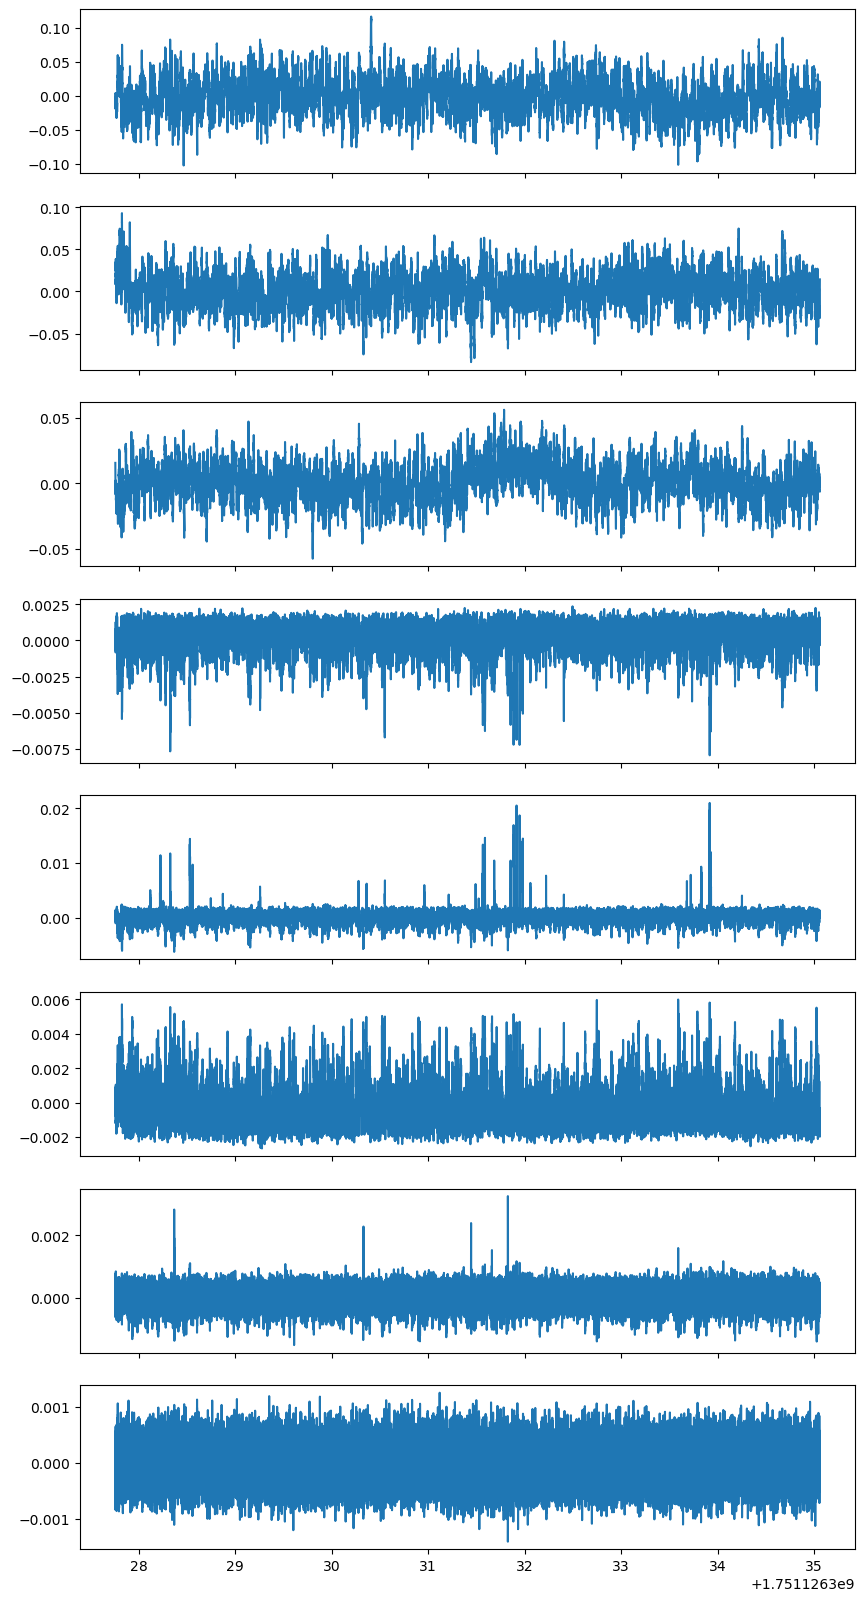

In [222]:
# fig, ax = plt.subplots(nrows=2, sharex=True, height_ratios=[1, 3], figsize=(10, 5))
ind = slice(21000, 64000)

ind = slice(21000, 71000)
# ind = slice(21000, 121000)
# ind = slice(200000, 210000,1)
# ind = slice(12000,12300)
fig, ax = plt.subplots(nrows=8, figsize=(10, 20), sharex=True)
for i, a in enumerate(ax):
    a.plot(analysis.t[ind], analysis.c_pca[ind, i])


# ax[1].plot(analysis.t[ind], analysis.c_pca[ind, :10])
# # plot_interval = Interval(np.array([[analysis.t[ind][0], analysis.t[ind][-1]]]))
# # behavior_inds = plot_interval.contains(t, as_indices=True)
# # ax[0].plot(t[behavior_inds], thetaphase[behavior_inds], c="k")
# print(analysis.pca.explained_variance_ratio_ * 100)
# ax[0].set_ylabel("theta phase")
# ax[1].set_ylabel("context variables")

[5.28610629e+01 3.17854163e+01 1.45186104e+01 3.06190954e-01
 2.94641228e-01 1.66363999e-01 2.26961932e-02 1.08582815e-02
 6.79844460e-03 6.34958817e-03 4.58964083e-03 3.77088975e-03
 2.77251463e-03 2.66771887e-03 2.35415038e-03 1.47001095e-03
 1.31173032e-03 9.27188159e-04 6.65439622e-04 4.82539141e-04]


Text(0, 0.5, 'context variables')

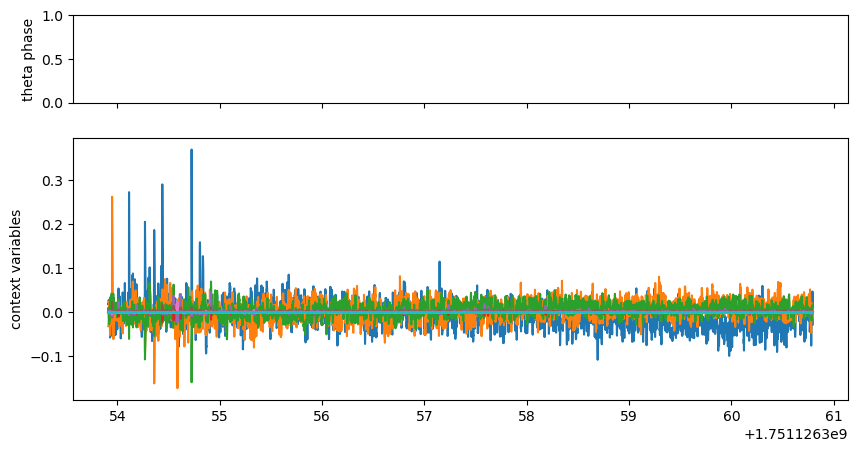

In [219]:
fig, ax = plt.subplots(nrows=2, sharex=True, height_ratios=[1, 3], figsize=(10, 5))
ind = slice(21000, 44000)

ind = slice(21000, 30000)
ind = slice(200000, 250000, 10)
# ind = slice(12000,12300)
# fig, ax = plt.subplots(nrows=16, figsize=(10, 20), sharex=True)
# for i, a in enumerate(ax):
#     a.plot(analysis.t[ind], analysis.c_pca[ind, i])


ax[1].plot(analysis.t[ind], analysis.c_pca[ind, :10])
# plot_interval = Interval(np.array([[analysis.t[ind][0], analysis.t[ind][-1]]]))
# behavior_inds = plot_interval.contains(t, as_indices=True)
# ax[0].plot(t[behavior_inds], thetaphase[behavior_inds], c="k")
print(analysis.pca.explained_variance_ratio_ * 100)
ax[0].set_ylabel("theta phase")
ax[1].set_ylabel("context variables")

# Store